# Changes in US Industrial Production
Industrial production consists of manufacturing of durable and non-durable (e.g. food, textile, etc.) goods, mining (mining, quarrying, and oil and gas extraction), and production of utilities (electricity and natural gas). Different countries have a different share of industrial production in their GDP, with developed economies tending to have a smaller portion of industrial production in their GDP. In the US industrial production makes up about 14.5% of the GDP.

Since industrial production is measured based on an index chained to a particular year, it communicates _real_ changes in production.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.ticker as mtick
import pandas_datareader.data as web
from datetime import date

In [2]:
report_start = date.fromisoformat('1959-01-01')
report_end = date.today()

In [3]:
INDPRO_SICS_COLUMN_NAME = 'Manufacturing'
INDPRO_MINE_COLUMN_NAME = 'Mining'
INDPRO_UTIL_COLUMN_NAME = 'Utilities'

## Share of Industrial production in US GDP

In [4]:
indpro_gdp_share = web.get_data_fred(['VAPGDPMA', 'VAPGDPM', 'VAPGDPU'], start=report_start, end=report_end) / 100.
indpro_gdp_share['Total'] = indpro_gdp_share.sum(axis=1)
indpro_gdp_share = indpro_gdp_share.rename(
    columns={'VAPGDPMA': INDPRO_SICS_COLUMN_NAME,
             'VAPGDPM': INDPRO_MINE_COLUMN_NAME, 'VAPGDPU': INDPRO_UTIL_COLUMN_NAME})
indpro_gdp_share = indpro_gdp_share.iloc[:, [-1, 0, 1, 2]]

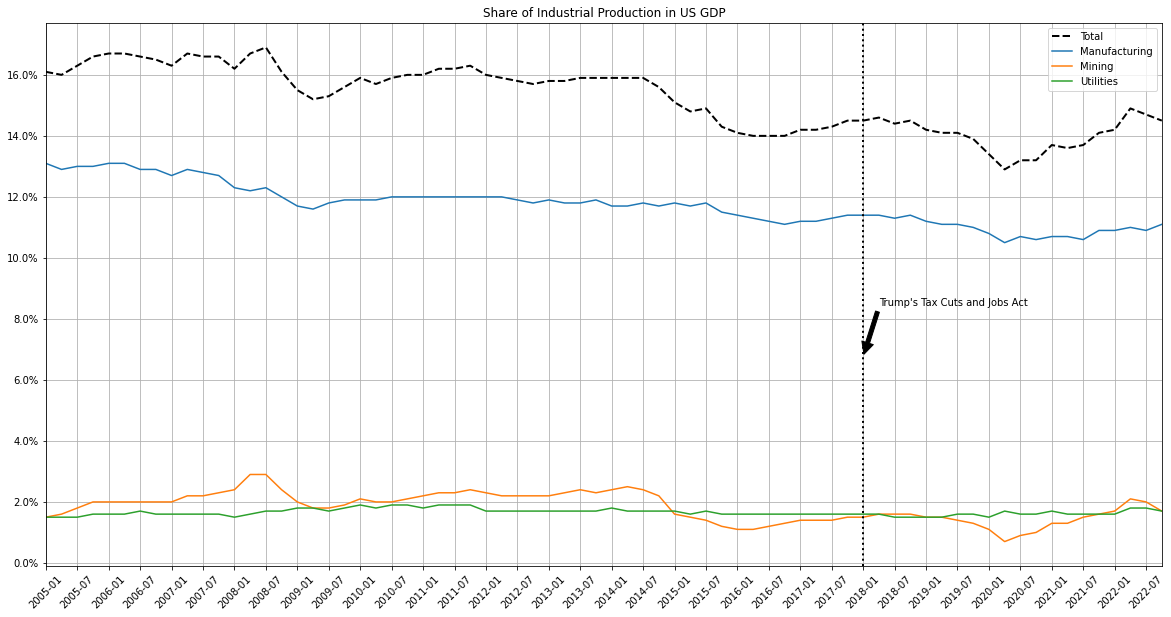

In [5]:
GRAPH_TITLE_INDPRO_GDP_SHARE = 'Share of Industrial Production in US GDP'
TAX_CUTS_DATE = '2018-1-1'
ax = indpro_gdp_share.iloc[:,:1].plot(figsize=(20,10), grid=True,
             title=GRAPH_TITLE_INDPRO_GDP_SHARE,
             xticks=indpro_gdp_share.index[::2], xlabel='', rot=45, linestyle='--', linewidth=2, color='k')
indpro_gdp_share.iloc[:,1:].plot(ax=ax, grid=True, xticks=indpro_gdp_share.index[::2], xlabel='', rot=45)
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.))
x1 = indpro_gdp_share.index[indpro_gdp_share.index.get_loc(TAX_CUTS_DATE)]
y1 = indpro_gdp_share.iloc[:,0].max() / 2.5
x2 = indpro_gdp_share.index[indpro_gdp_share.index.get_loc(TAX_CUTS_DATE) + 1]
y2 = y1 + indpro_gdp_share.iloc[:,0].max() / 10
ax.axvline(x1, color='k', linestyle=':', linewidth=2)
ax.annotate('Trump\'s Tax Cuts and Jobs Act',
            xy=(x1, y1), xytext=(x2, y2),
            arrowprops=dict(facecolor='black', shrink=0.05))
_ = ax.set_xticklabels(list(map('{:%Y-%m}'.format, indpro_gdp_share.index[::2])))

### High-level Composition of US Industrial Production

In [6]:
indpro_components = web.get_data_fred(['INDPRO', 'IPMANSICS', 'IPMINE', 'IPUTIL'], start=report_start, end=report_end)

In [7]:
GRAPH_TITLE_INDPRO_COMPOSITION = 'High-level Composition of US Industrial Poduction'
LEFT_Y_AXIS_LABEL = 'Sum of individual industrial production indicies'
indpro_components_stacked = indpro_components.rename(
    columns={'IPMANSICS': INDPRO_SICS_COLUMN_NAME,
             'IPMINE': INDPRO_MINE_COLUMN_NAME, 'IPUTIL': INDPRO_UTIL_COLUMN_NAME})

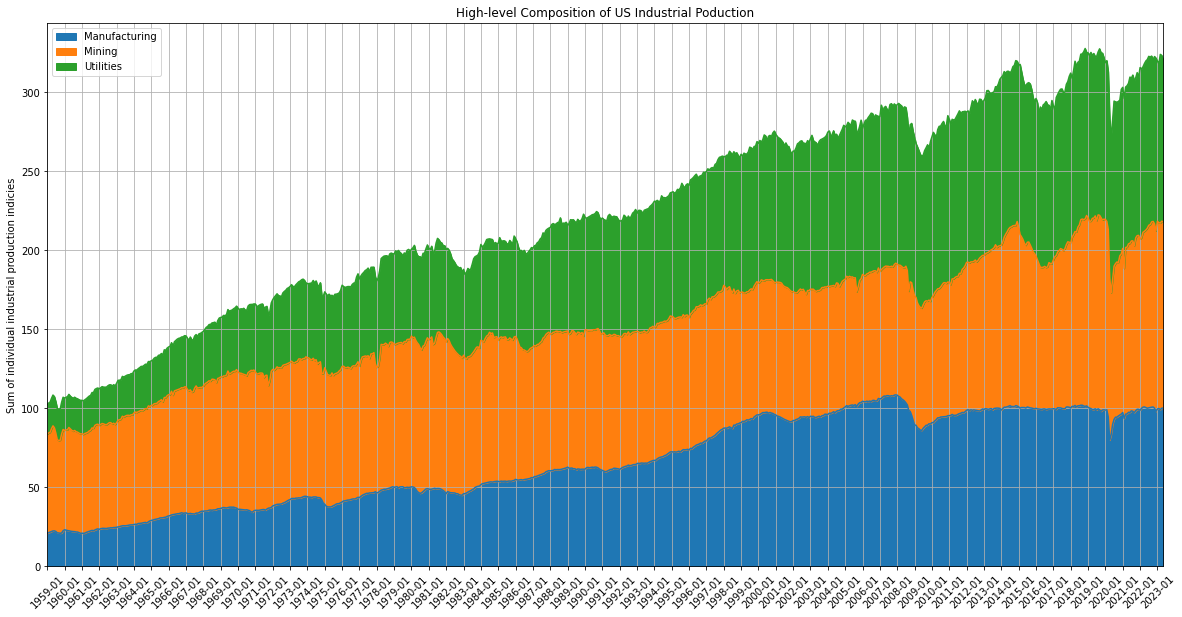

In [8]:
ax = indpro_components_stacked.iloc[:, 1:].plot.area(figsize=(20,10), grid=True, title=GRAPH_TITLE_INDPRO_COMPOSITION,
                          xticks=indpro_components_stacked.index[::12], xlabel='', rot=45,
                                                    ylabel=LEFT_Y_AXIS_LABEL)
_ = ax.set_xticklabels(list(map('{:%Y-%m}'.format, indpro_components_stacked.index[::12])))

In [9]:
# Converting to percentages by dividing by total
indpro_components_stacked_pct = indpro_components_stacked.iloc[:,1:].divide(
    indpro_components_stacked.iloc[:,1:].sum(axis=1), axis=0)

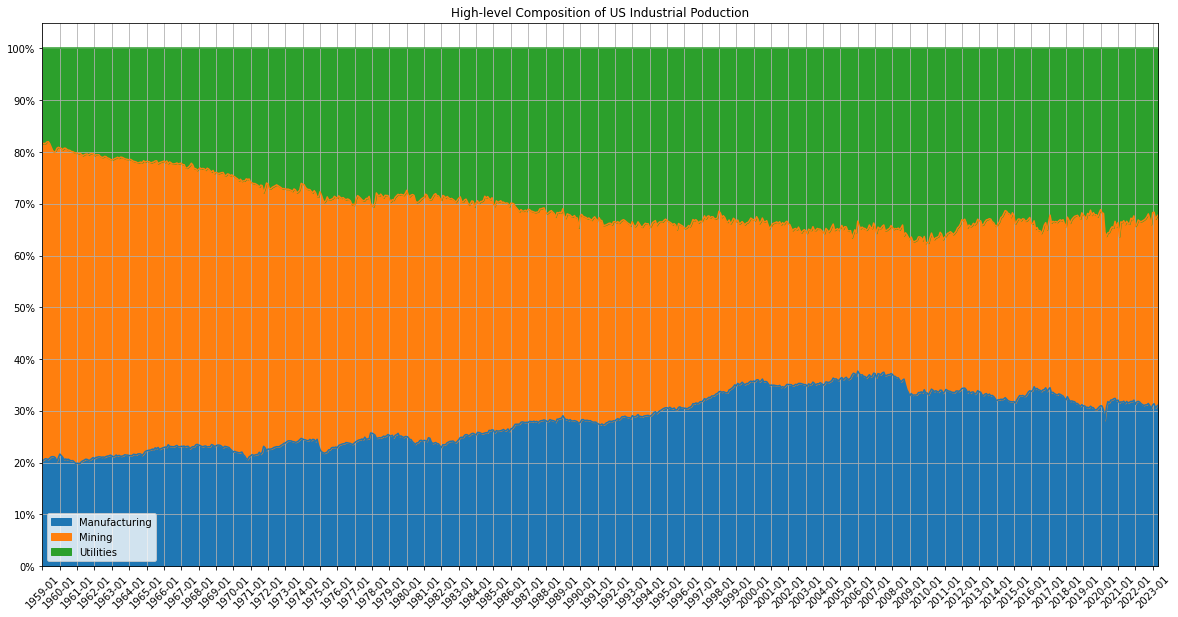

In [10]:
ax = indpro_components_stacked_pct.plot.area(figsize=(20,10), grid=True, title=GRAPH_TITLE_INDPRO_COMPOSITION,
                              xticks=indpro_components_stacked_pct.index[::12], xlabel='', rot=45,
                              yticks=np.arange(0, 1.01, .1))
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1))
_ = ax.set_xticklabels(list(map('{:%Y-%m}'.format, indpro_components_stacked_pct.index[::12])))

In [11]:
# Converting to annual percentage changes (changes from the corresponding month a year ago)
indpro_components.update(indpro_components.pct_change(12))
indpro_components = indpro_components.loc['2003':]

In [12]:
INDPRO_COLUMN_NAME = 'Industrial Production Annual Percentage Change'
INDPRO_SICS_COLUMN_NAME = 'Manufacturing Annual Percentage Change'
INDPRO_MINE_COLUMN_NAME = 'Mining Annual Percentage Change'
INDPRO_UTIL_COLUMN_NAME = 'Utilities Annual Percentage Change'
GRAPH_TITLE_INDPRO_COMPONENTS = 'Annual Percentage Changes in Main Components of US Industrial Production'
indpro_components.rename(
    columns={'INDPRO': INDPRO_COLUMN_NAME, 'IPMANSICS': INDPRO_SICS_COLUMN_NAME,
             'IPMINE': INDPRO_MINE_COLUMN_NAME, 'IPUTIL': INDPRO_UTIL_COLUMN_NAME},
    inplace=True)

In [13]:
pd.options.display.float_format = '{:.4%}'.format
pd.options.display.max_rows = 20
indpro_components.loc['2020-01':]

,Industrial Production Annual Percentage Change,Manufacturing Annual Percentage Change,Mining Annual Percentage Change,Utilities Annual Percentage Change
DATE,,,,
2020-01-01,-1.9311%,-1.7694%,0.6832%,-5.0650%
2020-02-01,-1.1633%,-1.1030%,0.8666%,-3.0369%
2020-03-01,-5.0194%,-5.3894%,0.1466%,-6.7821%
2020-04-01,-17.2621%,-19.5397%,-14.8826%,-2.4608%
2020-05-01,-16.0575%,-16.0556%,-25.9864%,-5.4831%
...,...,...,...,...
2023-01-01,1.4703%,0.8072%,9.6480%,-6.5628%
2023-02-01,0.8121%,-0.0379%,8.9248%,-5.9344%
2023-03-01,0.1699%,-1.5497%,6.6602%,2.0333%


### Zooming in on the current decade

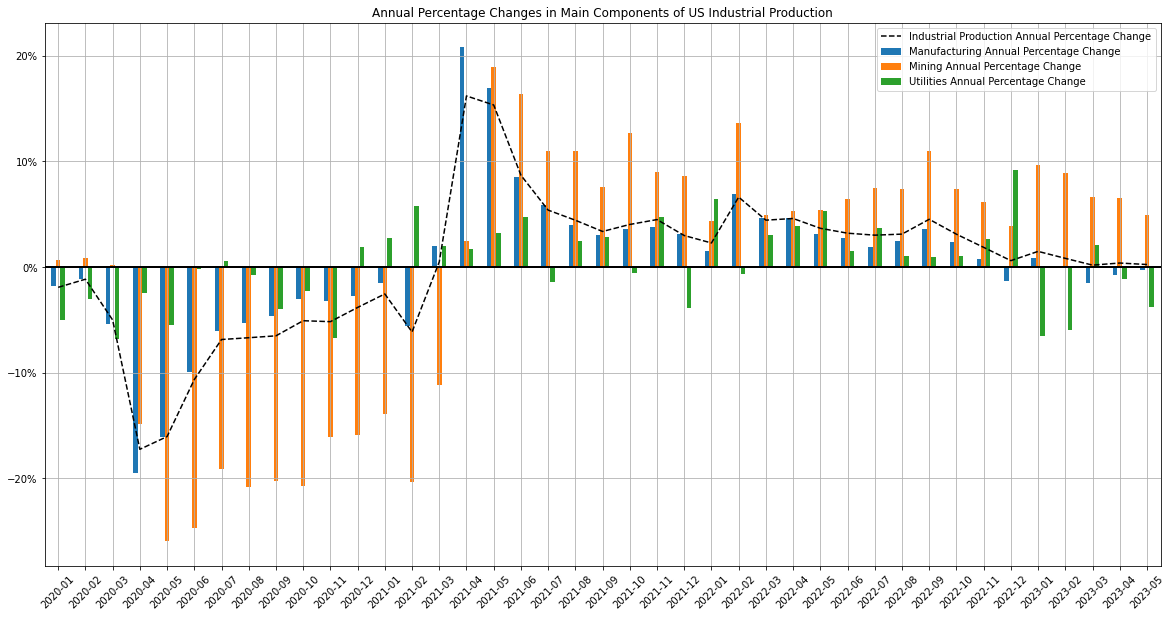

In [14]:
dt_from = date(2020, 1, 1)
indpro_components_recent = indpro_components.loc[dt_from:]
ax = indpro_components_recent.iloc[:,0].plot(figsize=(20,10), grid=True, title=GRAPH_TITLE_INDPRO_COMPONENTS,
                                          xlabel='', rot=45, linestyle='--', color='k', use_index=False)
indpro_components_recent.iloc[:,1:].plot.bar(ax=ax, grid=True, xlabel='', rot=45)
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1))
ax.axhline(y=0, lw=2, c='k')
ax.legend()
_ = ax.set_xticklabels(list(map('{:%Y-%m}'.format, indpro_components_recent.index)))

### Capacity Utilization of Main Components of US Industrial Production

In [15]:
indpro_utilization = web.get_data_fred(['TCU', 'CUMFNS', 'CAPUTLG21S', 'CAPUTLG2211A2S'], start=report_start, end=report_end) / 100.
dt_from = date(2018, 1, 1)
indpro_utilization = indpro_utilization.loc[dt_from:]

In [16]:
INDPRO_TOTAL_CU_COLUMN_NAME = 'Total Capacity Utilization'
INDPRO_SICS_CU_COLUMN_NAME = 'Manufacturing Capacity Utilization'
INDPRO_MINE_CU_COLUMN_NAME = 'Mining Capacity Utilization'
INDPRO_UTIL_CU_COLUMN_NAME = 'Utilities Capacity Utilization'
GRAPH_TITLE_INDPRO_CU = 'US Capacity Utilization'
indpro_utilization.rename(
    columns={'TCU': INDPRO_TOTAL_CU_COLUMN_NAME, 'CUMFNS': INDPRO_SICS_CU_COLUMN_NAME,
             'CAPUTLG21S': INDPRO_MINE_CU_COLUMN_NAME, 'CAPUTLG2211A2S': INDPRO_UTIL_CU_COLUMN_NAME},
    inplace=True)

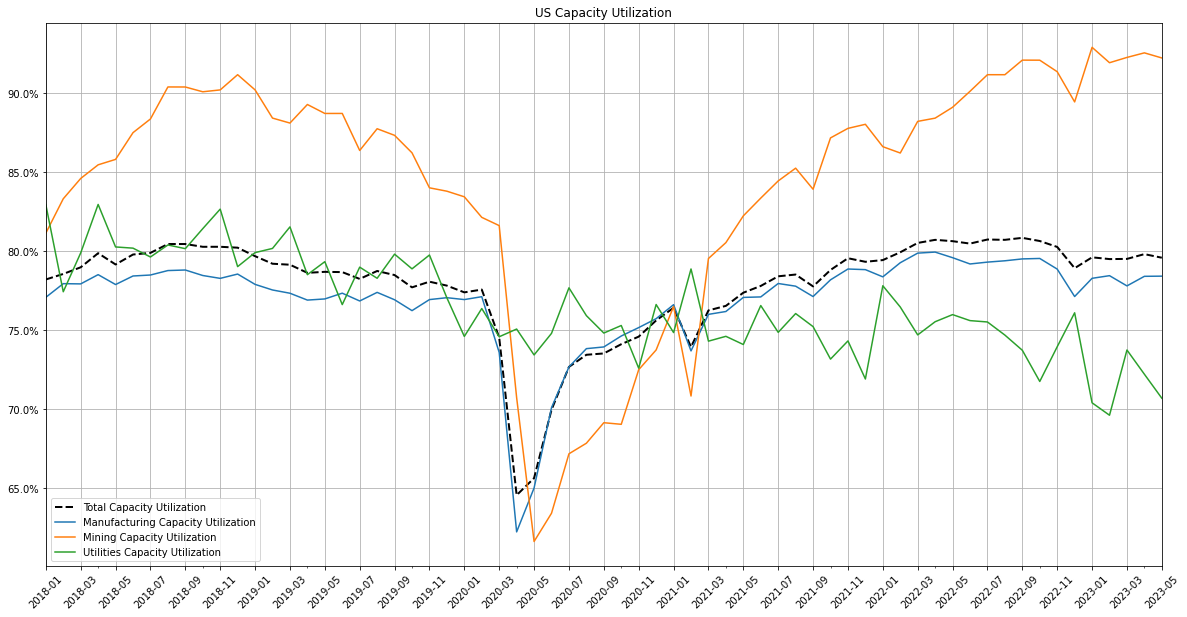

In [17]:
ax = indpro_utilization.iloc[:,:1].plot(figsize=(20,10), grid=True,
             title=GRAPH_TITLE_INDPRO_CU,
             xticks=indpro_utilization.index[::2], xlabel='', rot=45, linestyle='--', linewidth=2, color='k')
indpro_utilization.iloc[:,1:].plot(ax=ax, grid=True, xticks=indpro_utilization.index[::2], xlabel='', rot=45)
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.))
_ = ax.set_xticklabels(list(map('{:%Y-%m}'.format, indpro_utilization.index[::2])))

## Zooming in on the Manufacturing Industry Group

In [18]:
ipman_components = web.get_data_fred(['IPDMAN', 'IPNMAN', 'IPGMFOS'], start=report_start, end=report_end)

# Converting to annual percentage changes (changes from the corresponding month a year ago)
ipman_components.update(ipman_components.pct_change(12))
ipman_components = ipman_components.loc['2003':]
ipman_components = pd.concat([indpro_components.iloc[:,1], ipman_components], axis=1)

In [19]:
IPDMAN_COLUMN_NAME = 'Durable Manufacturing Annual Percentage Change'
IPNMAN_COLUMN_NAME = 'Non-Durable Manufacturing Annual Percentage Change'
IPGMFOS_COLUMN_NAME = 'Other Manufacturing Annual Percentage Change'
GRAPH_TITLE_IPDMAN_COMPONENTS = 'Annual Percentage Changes in Main Components of US Manufacturing'
ipman_components.rename(
    columns={'IPDMAN': IPDMAN_COLUMN_NAME, 'IPNMAN': IPNMAN_COLUMN_NAME,
             'IPGMFOS': IPGMFOS_COLUMN_NAME},
    inplace=True)

In [20]:
ipman_components.loc['2020-01':]

,Manufacturing Annual Percentage Change,Durable Manufacturing Annual Percentage Change,Non-Durable Manufacturing Annual Percentage Change,Other Manufacturing Annual Percentage Change
DATE,,,,
2020-01-01,-1.7694%,-2.7665%,-0.8154%,0.4281%
2020-02-01,-1.1030%,-2.0077%,-0.0993%,-1.5229%
2020-03-01,-5.3894%,-8.8837%,-1.3950%,-7.1019%
2020-04-01,-19.5397%,-27.8086%,-10.1966%,-20.5412%
2020-05-01,-16.0556%,-22.4746%,-8.7324%,-18.2717%
...,...,...,...,...
2023-01-01,0.8072%,1.8794%,-0.2779%,0.8017%
2023-02-01,-0.0379%,0.8124%,-0.9303%,0.6309%
2023-03-01,-1.5497%,-1.1086%,-1.8981%,-3.9755%


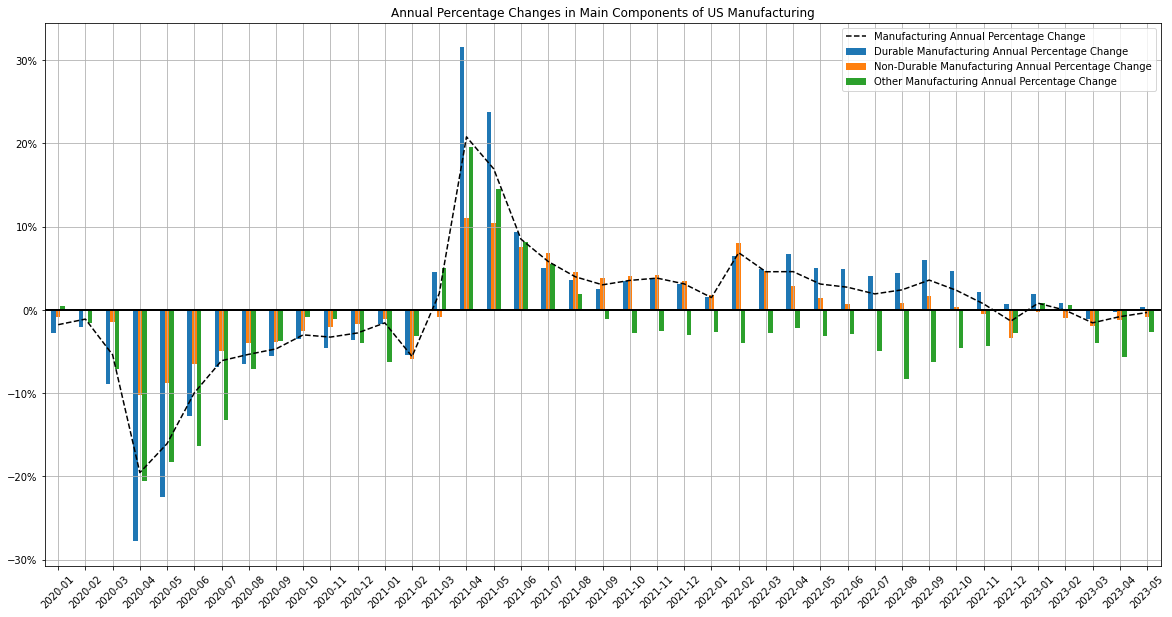

In [21]:
dt_from = date(2020, 1, 1)
ipman_components = ipman_components.loc[dt_from:]
ax = ipman_components.iloc[:,0].plot(figsize=(20,10), grid=True, title=GRAPH_TITLE_IPDMAN_COMPONENTS,
                                          xlabel='', rot=45, linestyle='--', color='k', use_index=False)
ipman_components.iloc[:,1:].plot.bar(ax=ax, grid=True, xlabel='', rot=45)
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1))
ax.axhline(y=0, lw=2, c='k')
ax.legend()
_ = ax.set_xticklabels(list(map('{:%Y-%m}'.format, ipman_components.index)))

### Capacity Utilization in Manufacturing

In [22]:
indman_utilization = web.get_data_fred(['CAPUTLGMFDS', 'CAPUTLGMFNS', 'CAPUTLGMFOS'], start=report_start, end=report_end) / 100.
dt_from = date(2018, 1, 1)
indman_utilization = pd.concat([indpro_utilization.iloc[:, 1], indman_utilization.loc[dt_from:]], axis=1)

In [23]:
IPDMAN_CU_COLUMN_NAME = 'Durable Manufacturing Capacity Utilization'
IPNMAN_CU_COLUMN_NAME = 'Non-Durable Manufacturing Capacity Utilization'
IPGMFOS_CU_COLUMN_NAME = 'Other Manufacturing Annual Capacity Utilization'
GRAPH_TITLE_INDMAN_CU = 'Capacity Utilization in US Manufacturing'
indman_utilization.rename(
    columns={'CAPUTLGMFDS': IPDMAN_CU_COLUMN_NAME, 'CAPUTLGMFNS': IPNMAN_CU_COLUMN_NAME,
             'CAPUTLGMFOS': IPGMFOS_CU_COLUMN_NAME},
    inplace=True)

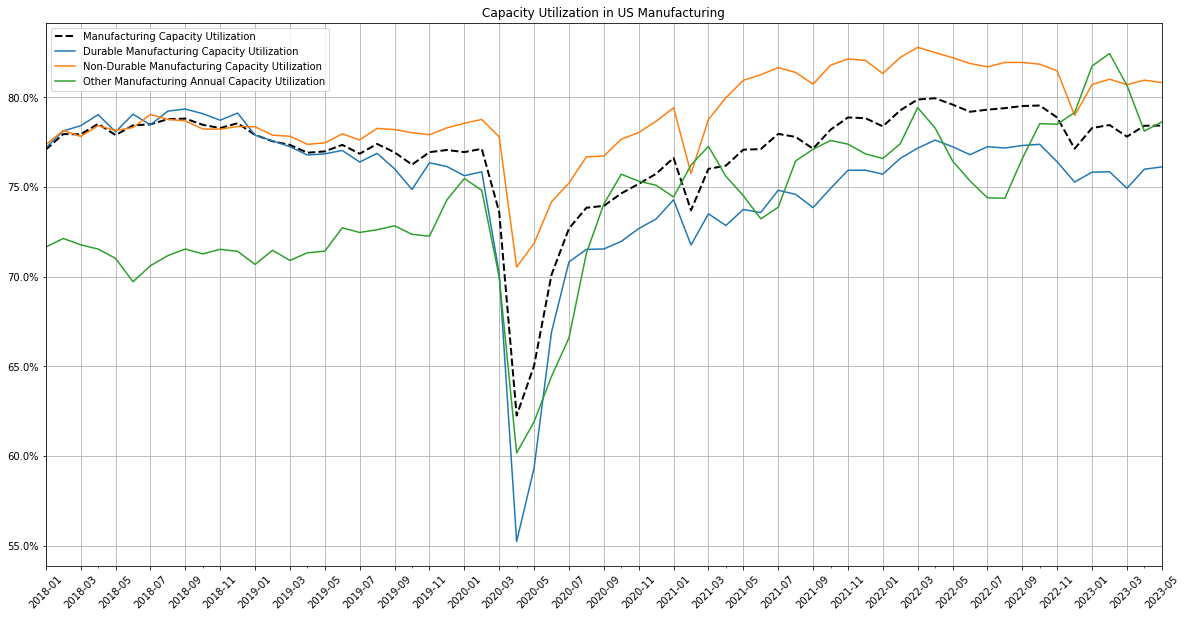

In [24]:
ax = indman_utilization.iloc[:,:1].plot(figsize=(20,10), grid=True,
             title=GRAPH_TITLE_INDMAN_CU,
             xticks=indman_utilization.index[::2], xlabel='', rot=45, linestyle='--', linewidth=2, color='k')
indman_utilization.iloc[:,1:].plot(ax=ax, grid=True, xticks=indman_utilization.index[::2], xlabel='', rot=45)
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.))
_ = ax.set_xticklabels(list(map('{:%Y-%m}'.format, indman_utilization.index[::2])))

## Zooming in on the Durable Manufacturing Industry Group

In [25]:
ipdman_components = web.get_data_fred(['IPG321S', 'IPG327S', 'IPG331S', 'IPG332S', 'IPG333S',
                                       'IPG334S', 'IPG335S', 'IPG3361T3S', 'IPG3364T9S',
                                       'IPG337S', 'IPG339S'], start=report_start, end=report_end)
# dt_from_ipdman = date(1970, 1, 1)
# ipdman_components = ipdman_components.loc[dt_from_ipdman:]

In [30]:
IPDMAN_WP_COLUMN_NAME = 'Wood Products'
IPDMAN_NMMP_COLUMN_NAME = 'Nonmetallic Mineral Product'
IPDMAN_PM_COLUMN_NAME = 'Primary Metals'
IPDMAN_FMP_COLUMN_NAME = 'Fabricated Metal Products'
IPDMAN_M_COLUMN_NAME = 'Machinery'
IPNMAN_CEP_COLUMN_NAME = 'Computer and Electronic Products'
IPDMAN_EE_COLUMN_NAME = 'Electrical Equipment'
IPDMAN_MVP_COLUMN_NAME = 'Motor Vehicles and Parts'
IPDMAN_AS_COLUMN_NAME = 'Aerospace'
IPDMAN_F_COLUMN_NAME = 'Furniture'
IPDMAN_MSC_COLUMN_NAME = 'Miscellaneous'
GRAPH_TITLE_IPDMAN_COMPONENTS = 'US Composition of Durable Manufacturing Industry Group'
ipdman_components.rename(
    columns={'IPG321S': IPDMAN_WP_COLUMN_NAME, 'IPG327S': IPDMAN_NMMP_COLUMN_NAME,
             'IPG331S': IPDMAN_PM_COLUMN_NAME, 'IPG332S': IPDMAN_FMP_COLUMN_NAME,
             'IPG333S': IPDMAN_M_COLUMN_NAME, 'IPG334S': IPNMAN_CEP_COLUMN_NAME,
             'IPG335S': IPDMAN_EE_COLUMN_NAME, 'IPG3361T3S': IPDMAN_MVP_COLUMN_NAME,
             'IPG3364T9S': IPDMAN_AS_COLUMN_NAME, 'IPG337S': IPDMAN_F_COLUMN_NAME,
             'IPG339S': IPDMAN_MSC_COLUMN_NAME},
    inplace=True)

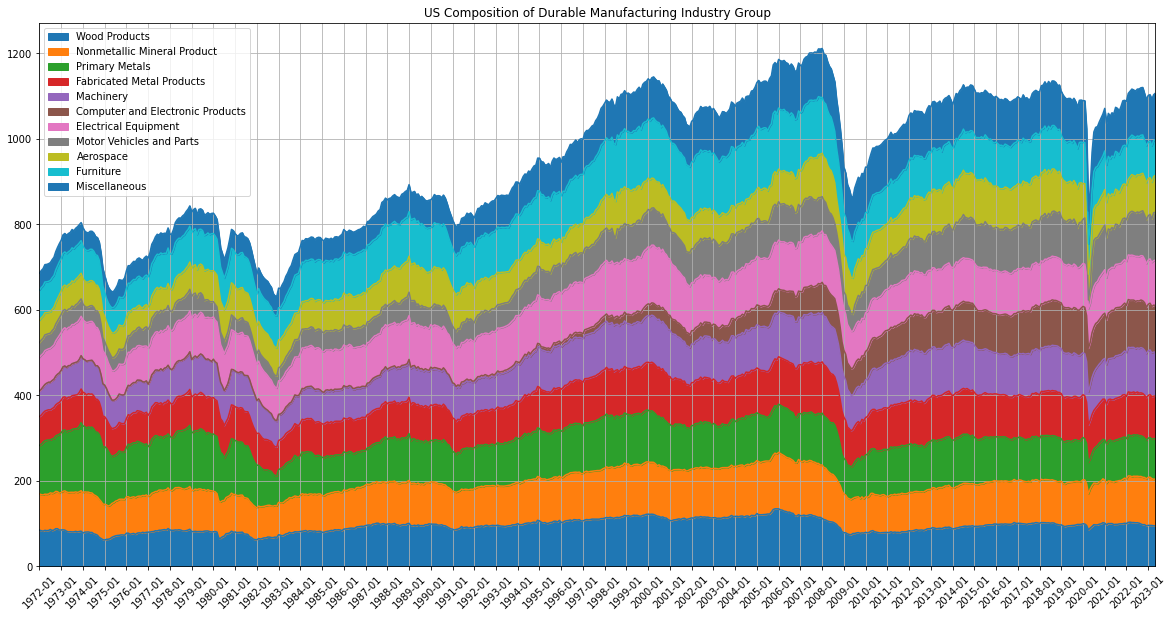

In [31]:
ax = ipdman_components.plot.area(figsize=(20,10), grid=True, title=GRAPH_TITLE_IPDMAN_COMPONENTS,
                          xticks=ipdman_components.index[::12], xlabel='', rot=45)
_ = ax.set_xticklabels(list(map('{:%Y-%m}'.format, ipdman_components.index[::12])))

In [32]:
# Converting to percentages by dividing by total
ipdman_components_pct = ipdman_components.divide(ipdman_components.sum(axis=1), axis=0)

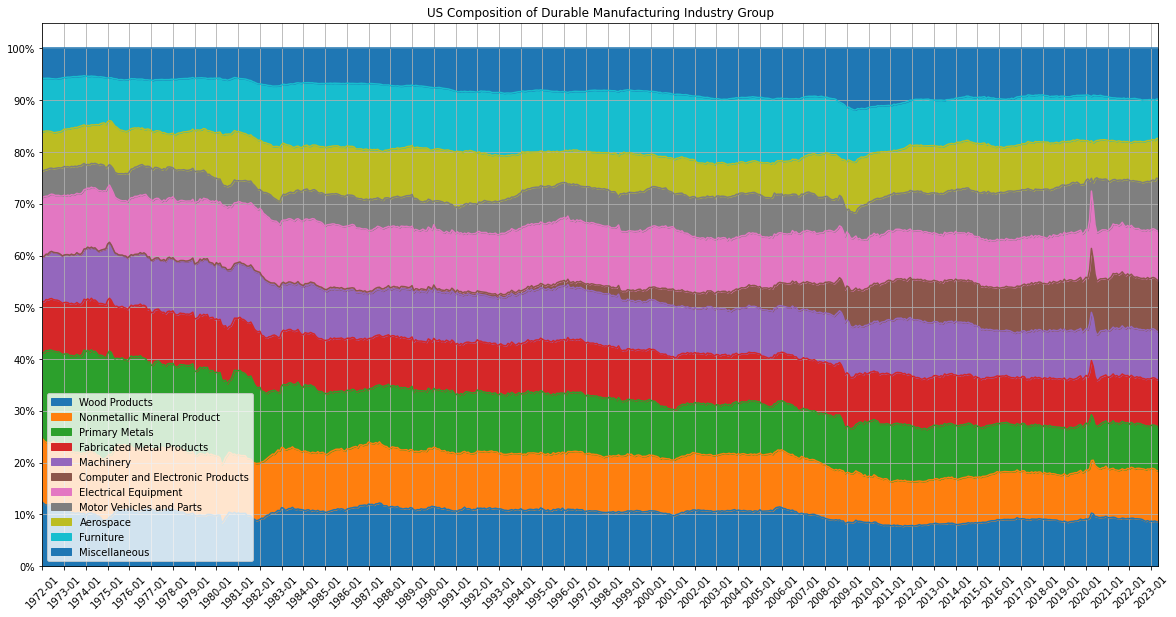

In [33]:
ax = ipdman_components_pct.plot.area(figsize=(20,10), grid=True, title=GRAPH_TITLE_IPDMAN_COMPONENTS,
                              xticks=ipdman_components_pct.index[::12], xlabel='', rot=45,
                              yticks=np.arange(0, 1.01, .1))
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1))
_ = ax.set_xticklabels(list(map('{:%Y-%m}'.format, ipdman_components_pct.index[::12])))